# 사과 종 분류 과제

## 데이터 구조

```
$ DATA/
├── train/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── test/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
├── train_labels.csv (코드 실행 후 생성)
└── valid_labels.csv (코드 실행 후 생성)
```



## 0. 사전 준비

### 필요 라이브러리 설치

In [1]:
!pip install timm
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 2.3 MB/s eta 0:00:00a 0:00:01


## 1. 라이브러리 불러오기

In [2]:
from torch.utils.data import DataLoader
import torch

from datetime import datetime, timezone, timedelta
import numpy as np
import random
import os
import copy

import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import random

import timm
from torch import nn

from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

## 2. 경로 / 기타 인자 설정

### 데이터 경로 설정

In [3]:
# 프로젝트 경로
PROJECT_DIR = '/kaggle/input/apple-data/'
os.chdir(PROJECT_DIR)

# 데이터 경로
DATA_DIR = os.path.join(PROJECT_DIR, 'DATA')
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'train.csv')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')
TEST_LABEL_DIR = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_DIR = os.path.join(DATA_DIR, 'sample_submission.csv')

In [4]:
# 파일 수 확인 
print(len(os.listdir(TRAIN_IMG_DIR)))
print(len(os.listdir(TEST_IMG_DIR)))

10000
5000


### 결과 저장 경로 설정

In [5]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join('/kaggle/working/', 'results', 'train', train_serial)
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    

### 시드 설정

In [6]:
# 시드
RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 디바이스 설정

In [7]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3. 데이터 불러오기 및 분할

### Train 라벨

In [8]:
# 학습 파일
traindf = pd.read_csv(TRAIN_LABEL_DIR)

traindf.head()

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG


### Train 이미지 예시

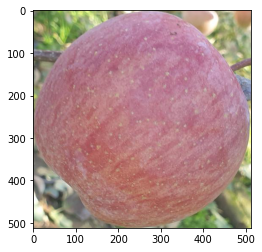

In [9]:
# 이미지 예시
example_index = random.randrange(len(traindf)) # 0,1,2,...
example_imageid = traindf['img_id'][example_index]
example_image_path = os.path.join(TRAIN_IMG_DIR, example_imageid)
example_image = Image.open(example_image_path)

plt.imshow(example_image)

### Train / Validation 분할

In [10]:
# 80% / 20% 비율로 분할
train,val = train_test_split(traindf, test_size=0.2, shuffle=True)

# # train / validation로 나눈 데이터 프레임 저장
# train.to_csv(os.path.join(DATA_DIR, 'train_labels.csv'), index=False)
# val.to_csv(os.path.join(DATA_DIR, 'val_labels.csv'),index=False)

## 4. Dataset 

### Dataset 클래스 정의

In [11]:
class AppleDataset(Dataset):
    def __init__(self, img_folder, labelpath):
        self.df = pd.read_csv(labelpath, usecols=['img_id','a_type'],dtype={'a_ty pe':str})
        self.label_encoding = {'HJ':0, 'HR':1, 'SG':2, 'AR':3}
        self.img_folder = img_folder
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])  
        self.img_ids = list(self.df['img_id'])
        self.labels = list(self.df['a_type'])
  
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        impath = os.path.join(self.img_folder, self.img_ids[index])
        img = Image.open(impath)
        img = self.transforms(img)
        lbl = self.labels[index]
        lbl = self.label_encoding[lbl]
        return img,lbl


## 5. 모델 정의

### 모델 Class 생성

In [12]:
F = nn.functional

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        # 합성곱 층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,3,3,4)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(3,3,3,padding=1)

        # 완전 연결 층
        self.fc1 = nn.Linear(3072, 1036)
        self.fc2 = nn.Linear(1036, 518)
        self.fc3 = nn.Linear(518, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)   
        return output

In [13]:
class EffNet(nn.Module):
    def __init__(self):
        super(EffNet, self).__init__()
        self.model = timm.create_model('efficientnet_b4', pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features = 1792, out_features = 625),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(625,256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True
  
    def forward(self, x):
        output = self.model(x)
        return output

In [14]:
class BasicBlock(nn.Module) :
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=False) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stirde, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
            
        if downsample : # 다운샘플이 적용되는 부분(출력 데이터크기가 다를 경우 사용)
            conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                            stride=stride, bias=False)
            
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
            
        else :
            downsample = None
        self.downsample = downsample
        
    def forward(self, x) :
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None :
            i = self.downsample(i)
            
        x += i # identity mapping
        x = self.relu(x)
        
        return x

In [15]:
class Bottleneck(nn.Module) :
    expansion = 4 # 병목 블록을 정의하기 위한 하이퍼파라미터
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=False) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                              stride=1, bias=False) # 1x1 합성곱층
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, 
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        if downsample : 
            conv = nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1,
                            stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_channels)
            downsample = nn.Sequential(conv, bn)
        else :
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x) :
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None : 
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
        
        return x

In [16]:
class ResNet(nn.Module) :
    def __init__(self, config, output_dim, zero_init_residual=False) :
        super().__init__()
       
        block, n_blocks, channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len(channels) == 4
       
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2,
                             padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
       
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[1], channels[2], stride=2)        
        self.layer4 = self.get_resnet_layer(block, n_blocks[1], channels[3], stride=2)
       
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, output_dim)

       
        if zero_init_residual :
            for m in self.modules() :
                if isinstance(m, BottleNeck) :
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock) :
                    nn.init.constant_(m.bn2.weight, 0)
                   
    def get_resnet_layer(self, block, n_blocks, channels, stride=1) : 
        layers = []
        if self.in_channels != block.expansion * channels : 
            downsample = True 
        else :
            downsample = False
           
        layers.append(block(self.in_channels, channels, stride, downsample))
       
        for i in range(1, n_blocks) :
            layers.append(block(block.expansion*channels, channels))
           
        self.in_channels = block.expansion * channels
        return nn.Sequential(*layers)

   
    def forward(self, x) : 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h
       
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [17]:
# 기본
resnet18_config = ResNetConfig(block=BasicBlock,
                             n_blocks=[2, 2, 2, 2,],
                             channels=[64, 128, 256, 512])

resnet34_config = ResNetConfig(block=BasicBlock,
                             n_blocks=[3, 4, 6, 3,],
                             channels=[64, 128, 256, 512])
# 병목
resnet50_config = ResNetConfig(block=Bottleneck,
                             n_blocks=[3, 4, 6, 3],
                             channels=[64,128,256,512])

resnet101_config = ResNetConfig(block=Bottleneck,
                             n_blocks=[3,4,23,3],
                             channels=[64,128,256,512])

resnet152_config = ResNetConfig(block=Bottleneck,
                              n_blocks=[3,8,36,3],
                              channels=[64,128,256,512])

### 모델 선택 함수

In [18]:
def get_model(model_name:str):
    if model_name == 'Custom':
        return CustomNet()
    if model_name == 'effnet':
        return EffNet()
    if model_name == 'resnet':
        return ResNet(resnet152_config, 4)

## 6. 학습

### DataLoader 관련 인자 설정

In [19]:
# Dataloader 관련 인자
BATCH_SIZE = 16
NUM_WORKERS = 1
SHUFFLE = True
PIN_MEMORY = True
DROP_LAST = False

### Dataset 및 DataLoader 생성



In [20]:
# 데이터 셋 정의
train_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'train_labels.csv'))
valid_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'val_labels.csv'))

# 데이터 로더 정의
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

### 모델 설정

In [21]:
# Hyperparameter 설정
# LEARNING_RATE = 2.5000e-05 
LEARNING_RATE = 5e-5
EPOCHS = 20

In [22]:
# 모델 불러오기
model = get_model('resnet')
model.to(device)

# Loss와 optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### 학습 진행

In [23]:
best_loss = np.Inf

for epoch in range(EPOCHS):
    ### 학습 ###
    model.train()  # 모델 학습 적용

    train_total_loss = 0
    target_list = [] # 실제 사과 종 추가할 리스트 
    pred_list = []  # 예측 사과 종 추가할 리스트

    # train
    for batch_index, (x,y) in tqdm(enumerate(train_dataloader)):
        x,y = x.to(device), y.to(device)                          # x - image data, y - 실제 label을 GPU로 옮김 
        y_pred = model(x)                                         # 모델을 통해 나온 output
        loss = criterion(y_pred[0], y)                               # 실제값 y와 예측값 y_pred로 loss 계산
        optimizer.zero_grad()                                     # optimizer 초기화
        loss.backward()                                           # gradient 계산
        optimizer.step()                                          # 역전파
        train_total_loss += loss.item()                           # train_total_loss에 loss값을 누적
        pred_list.extend(y_pred[0].argmax(dim=1).cpu().tolist())     # 예측한 값중 가장 높은 값의 인덱스를 추가
        target_list.extend(y.cpu().tolist())                      # 실제 label 인덱스를 추가 
    train_mean_loss = train_total_loss / batch_index            # 에폭의 평균 loss
    train_accuracy = accuracy_score(target_list, pred_list)     # accuracy_score
    train_f1score = f1_score(target_list, pred_list, average='macro')  # macro - f1 Score

  ### 검증 ###
    model.eval()                                                # 학습 모드를 검증 모드로 변경
    val_total_loss = 0                                          
    target_list = []                                            
    pred_list = []
    with torch.no_grad():                                       # 역전파 하지 않음
        for batch_index, (x,y) in tqdm(enumerate(valid_dataloader)):    
            x = x.to(device)                                         
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred[0], y)
            val_total_loss += loss.item()
            target_list.extend(y.cpu().tolist())
            pred_list.extend(y_pred[0].argmax(dim=1).cpu().tolist())
    val_mean_loss = val_total_loss / batch_index
    val_accuracy = accuracy_score(target_list, pred_list)
    val_f1score = f1_score(target_list, pred_list, average='macro')

    msg1 = f"Epoch {epoch}/{EPOCHS} - Train loss: {train_mean_loss}; Train Accuracy: {train_accuracy}; Train F1: {train_f1score}"
    msg2 = f"Valid loss: {val_mean_loss}; Val Accuracy: {val_accuracy}; Val F1: {val_f1score}"
    print(msg1)
    print(msg2)

    ### 결과 저장 ###
    # validation loss가 개선될 때 모델 저장
    if val_mean_loss < best_loss:                               
        best_loss = val_mean_loss
        check_point = {                                         
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(check_point, os.path.join(RECORDER_DIR,'best.pt')) 


500it [06:16,  1.33it/s]
125it [00:45,  2.77it/s]


Epoch 0/20 - Train loss: 0.5212696955272395; Train Accuracy: 0.817625; Train F1: 0.6973313922848273
Valid loss: 0.4987100532218333; Val Accuracy: 0.874; Val F1: 0.7172576286280167


500it [06:09,  1.35it/s]
125it [00:29,  4.29it/s]


Epoch 1/20 - Train loss: 0.33573401880213516; Train Accuracy: 0.886625; Train F1: 0.8114893660975596
Valid loss: 0.2659458620699062; Val Accuracy: 0.9185; Val F1: 0.8453328611420844


500it [06:09,  1.35it/s]
125it [00:29,  4.19it/s]

Epoch 2/20 - Train loss: 0.27401818677163375; Train Accuracy: 0.906625; Train F1: 0.8519799295063955
Valid loss: 0.29641686899647596; Val Accuracy: 0.908; Val F1: 0.8532015065483969



500it [06:09,  1.35it/s]
125it [00:29,  4.21it/s]

Epoch 3/20 - Train loss: 0.22219748958527205; Train Accuracy: 0.925; Train F1: 0.8791970302394818
Valid loss: 0.2834727570692438; Val Accuracy: 0.912; Val F1: 0.8738199425463502



500it [06:09,  1.35it/s]
125it [00:29,  4.29it/s]


Epoch 4/20 - Train loss: 0.20051149604375473; Train Accuracy: 0.931375; Train F1: 0.8939391467610097
Valid loss: 0.17430374668835993; Val Accuracy: 0.939; Val F1: 0.8993517181000874


500it [06:09,  1.35it/s]
125it [00:29,  4.22it/s]

Epoch 5/20 - Train loss: 0.1765426515773282; Train Accuracy: 0.936625; Train F1: 0.9062240125346482
Valid loss: 0.18880096046561975; Val Accuracy: 0.947; Val F1: 0.9148734326439143



500it [06:09,  1.35it/s]
125it [00:29,  4.28it/s]


Epoch 6/20 - Train loss: 0.16933648665071668; Train Accuracy: 0.943375; Train F1: 0.9144916728498081
Valid loss: 0.16823610810623055; Val Accuracy: 0.9425; Val F1: 0.9147033757834574


500it [06:09,  1.35it/s]
125it [00:29,  4.28it/s]


Epoch 7/20 - Train loss: 0.15798575529699888; Train Accuracy: 0.943875; Train F1: 0.9144734513187277
Valid loss: 0.15369494628318917; Val Accuracy: 0.949; Val F1: 0.9175007130650078


500it [06:09,  1.35it/s]
125it [00:29,  4.17it/s]

Epoch 8/20 - Train loss: 0.15756772501386687; Train Accuracy: 0.946; Train F1: 0.9184474294966581
Valid loss: 0.1971831156894745; Val Accuracy: 0.939; Val F1: 0.9051209448598759



500it [06:09,  1.35it/s]
125it [00:29,  4.24it/s]

Epoch 9/20 - Train loss: 0.13750969647161124; Train Accuracy: 0.954125; Train F1: 0.9354863985631217
Valid loss: 0.16108043032750907; Val Accuracy: 0.947; Val F1: 0.9137398725927824



500it [06:09,  1.35it/s]
125it [00:29,  4.22it/s]

Epoch 10/20 - Train loss: 0.12088396222534065; Train Accuracy: 0.956625; Train F1: 0.935025548911561
Valid loss: 0.16904945112389302; Val Accuracy: 0.946; Val F1: 0.9138878294173286



500it [06:09,  1.35it/s]
125it [00:29,  4.18it/s]

Epoch 11/20 - Train loss: 0.1307297891042268; Train Accuracy: 0.951875; Train F1: 0.9275741235315901
Valid loss: 0.17565085082371237; Val Accuracy: 0.9465; Val F1: 0.9151237028000954



500it [06:09,  1.35it/s]
125it [00:29,  4.23it/s]

Epoch 12/20 - Train loss: 0.11332683224055565; Train Accuracy: 0.961125; Train F1: 0.9427842153863736
Valid loss: 0.19174690592861285; Val Accuracy: 0.9395; Val F1: 0.9056031214402531



500it [06:09,  1.35it/s]
125it [00:29,  4.22it/s]

Epoch 13/20 - Train loss: 0.11327656334847443; Train Accuracy: 0.962; Train F1: 0.9427668062118828
Valid loss: 0.33449779075360103; Val Accuracy: 0.8835; Val F1: 0.8290812292216927



500it [06:09,  1.35it/s]
125it [00:29,  4.25it/s]


Epoch 14/20 - Train loss: 0.11080278001736406; Train Accuracy: 0.962875; Train F1: 0.9459057018210171
Valid loss: 0.14763798912979603; Val Accuracy: 0.9495; Val F1: 0.9168757620703136


500it [06:09,  1.35it/s]
125it [00:29,  4.20it/s]

Epoch 15/20 - Train loss: 0.0904907516871284; Train Accuracy: 0.967375; Train F1: 0.9509793389912742
Valid loss: 0.18058613749810554; Val Accuracy: 0.9445; Val F1: 0.9123913536408533



500it [06:09,  1.35it/s]
125it [00:29,  4.30it/s]


Epoch 16/20 - Train loss: 0.08713788123272233; Train Accuracy: 0.969; Train F1: 0.9563255598061124
Valid loss: 0.12980553632247216; Val Accuracy: 0.953; Val F1: 0.9216435080195631


500it [06:09,  1.35it/s]
125it [00:33,  3.70it/s]

Epoch 17/20 - Train loss: 0.07512986703093662; Train Accuracy: 0.974375; Train F1: 0.9614106004218954
Valid loss: 0.17901761263971322; Val Accuracy: 0.947; Val F1: 0.9174103946691975



500it [06:09,  1.35it/s]
125it [00:29,  4.22it/s]

Epoch 18/20 - Train loss: 0.08270647094871024; Train Accuracy: 0.971875; Train F1: 0.961478639498151
Valid loss: 0.19694637912095547; Val Accuracy: 0.939; Val F1: 0.8967995995433398



500it [06:09,  1.35it/s]
125it [00:29,  4.27it/s]

Epoch 19/20 - Train loss: 0.07154260577194445; Train Accuracy: 0.9765; Train F1: 0.9633510760529129
Valid loss: 0.22699041700604627; Val Accuracy: 0.938; Val F1: 0.9014876991514802


## 7. 추론

### 데이터 셋 설정

In [24]:
class TestDataset(Dataset):
    def __init__(self, img_folder, labelpath):
        self.df = pd.read_csv(labelpath , usecols=['img_id'],dtype={'img_id':str})
        self.img_folder = img_folder
        self.transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
        self.img_ids = list(self.df['img_id'])
      
    def __len__(self):
        return len(self.img_ids)
  
    def __getitem__(self, index):
        impath = os.path.join(self.img_folder, self.img_ids[index])
        img = Image.open(impath)
        img = self.transforms(img)
        img_ids = self.img_ids[index]

        return img,img_ids

#### 모델설정

In [25]:
# 모델 Load
model = get_model('resnet')
checkpoint = torch.load(os.path.join(RECORDER_DIR, 'best.pt'))
model.load_state_dict(checkpoint['model'])
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Dataset 및 DataLoader 설정

In [26]:
# Dataloader 관련 인자
BATCH_SIZE = 1
NUM_WORKERS = 1
SHUFFLE = False
PIN_MEMORY = True
DROP_LAST = False

In [28]:
# Dataset
test_dataset = TestDataset(img_folder = TEST_IMG_DIR, labelpath = os.path.join(TEST_LABEL_DIR))


# DataLoader
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)             

### 추론 진행

In [29]:
model.eval()      # 학습 모드를 검증 모드로 변경

# 예측 진행
y_preds = []
img_ids = []

for batch_index, (x, img_id) in enumerate(tqdm(test_dataloader)):
    x = x.to(device, dtype=torch.float)
    y_logits = model(x)[0].cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_pred = y_pred.cpu().tolist()
    img_ids.extend(img_id)
    y_preds.extend(y_pred)

100%|██████████| 5000/5000 [02:36<00:00, 31.91it/s]


### 추론 결과 저장

In [30]:
# 결과 데이터 프레임 생성 및 라벨 디코딩
pred_df = pd.DataFrame(list(zip(img_ids, y_preds)), columns=['img_id','a_type'])
label_decoding = {0:'HJ', 1:'HR', 2:'SG', 3:'AR'}
pred_df['a_type'] = pred_df['a_type'].replace(label_decoding)

In [31]:
# 샘플과 동일한 순서로 변경
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['img_id'])
resdf = pred_df.set_index('img_id')
result = resdf.loc[sorter].reset_index()

In [32]:
result

,img_id,a_type
0,VXKQzkmgbf.jpg,HJ
1,2JFr2uJU79.jpg,HJ
2,twROnuoPeB.jpg,HR
3,b8mY8Szmhb.jpg,HJ
4,tcPc4JOUkG.jpg,HR
...,...,...
4995,kUAVadtfy1.jpg,HJ
4996,qXGjcfOaj4.jpg,HJ
4997,xLnjiHkkp9.jpg,SG
4998,Hvf9rxz3FM.jpg,HJ


In [33]:
result.to_csv(os.path.join(RECORDER_DIR,'result.csv'),index=False)